# Root Finding by Interval Halving (Bisection)

**References:**
- Section 1.1 *The Bisection Method* in *Numerical Analysis* by Sauer {cite}`Sauer`
- Section 2.1 *The Bisection Method* in *Numerical Analysis* by Burden, Faires and Burden {cite}`Burden-Faires`

(See the [Bibliography](bibliography.ipynb).)

## Introduction

One of the most basic tasks in numerical computing is finding the roots (or "zeros") of a function — solving the equation $f(x) = 0$ where $f:\mathbb{R} \to \mathbb{R}$ is a continuous function from and to the real numbers.
As with many topics in this course, there are multiple methods that work, and we will often start with the simplest and then seek improvement in several directions:
- **reliability** or *robustness* — how good it is at avoiding problems in hard cases, such as division by zero.

- *accuracy* and guarantees about accuracy like estimates of how large the error can be — since in most cases, the result cannot be computed exactly.

- *speed* or *cost* — often measured by minimizing the amount of arithmetic involved, or the number of times that a function must be evaluated.

We use the package PyPlot; see the notes on [plotting graphs](julia-language-notes#plottingwithpyplot) and on
[using package and modules](julia-language-notes#modules) in {doc}`julia-language-notes`.

In [1]:
using PyPlot

````{prf:example} Solve $x = \cos x$
:label: bisection-x-cosx
This is a simple equation for which there is no exact formula for a solution,
but we can easily ensure that there is a solution, and moreover, a unique one.
It is convenient to put the equation into "zero-finding" form $f(x) = 0$, by defining

$$f(x) := x - \cos x.$$

Also, note that $|\cos x| \leq 1$, so a solution to the original equation must have $|x| \leq 1$.
So we will start graphing the function on the interval
$[a, b] = [-1, 1]$.
````

In [2]:
f(x) = x - cos(x);

```{prf:remark} On Julia
:label: julia-function-short-form
For notes on this compact version of Julia function syntax, see [Functions, part 1](julia-language-notes#functions1) in {doc}`julia-language-notes`.
```

In [3]:
a = -1.0
b = 1.0;

```{prf:remark} On Julia
:label: julia-range
See the notes on the function [range](julia-language-notes#range) used below in {doc}`julia-language-notes`.
```

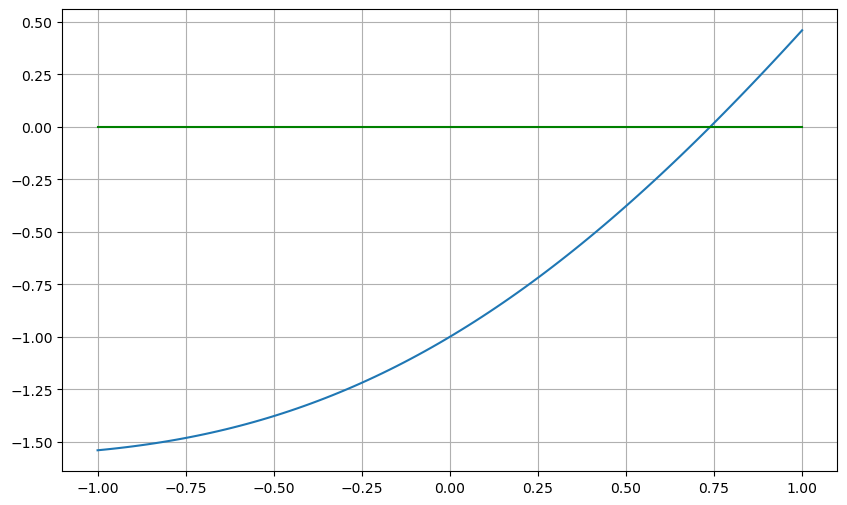

In [4]:
x = range(a, b, 100)
figure(figsize=[10,6])
plot(x, f.(x));
plot([a, b], [0, 0], "g");  # Mark the x-axis in green
grid(true)  # Add a graph paper background

This shows that the zero lies between 0.5 and 0.75, so zoom in:

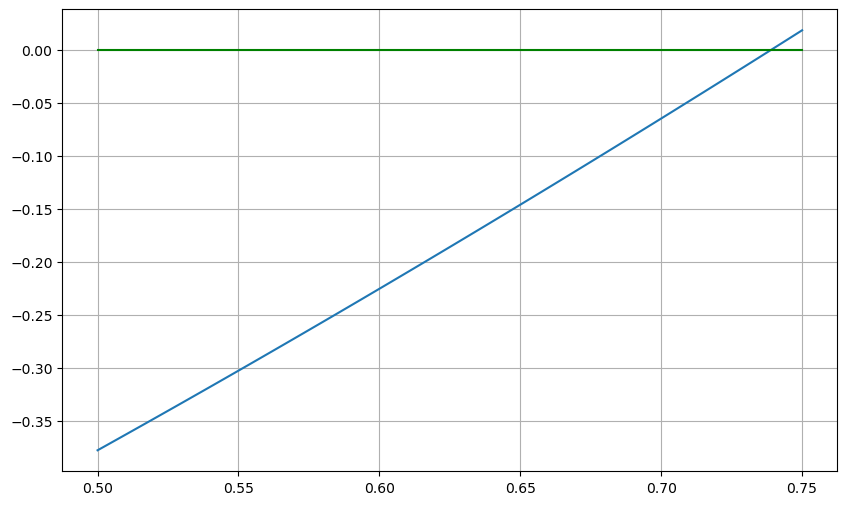

In [5]:
a = 0.5
b = 0.75
x = range(a, b, 100)
figure(figsize=[10,6])
plot(x, f.(x))
plot([a, b], [0, 0], "g")
grid(true)

And we could repeat, geting an approximation of any desired accuracy.

However this has two weaknesses: it is very inefficient (the function is evaluated about fifty times at each step in order to draw the graph), and it requires lots of human intervention.

To get a procedure that can be efficiently implemented in Julia (or another programming language of your choice),
we extract one key idea here: finding an interval in which the function changes sign, and then repeatedly find a smaller such interval within it.
The simplest way to do this is to repeatedly divide an interval known to contain the root in half and check which half has the sign change in it.

Graphically, let us start again with interval $[a, b] = [-1, 1]$, but this time focus on three points of interest: the two ends and the midpoint, where the interval will be bisected:

In [6]:
a = -1.0
b = 1.0
c = (a+b)/2
println("a=$a, b=$b, c=$c")

a=-1.0, b=1.0, c=0.0


```{prf:remark} On Julia
:label: julia-println
If you are unfamiliar with `println` see the notes on [Displaying values](julia-language-notes#displayingvalues) in {doc}`julia-language-notes`.
```

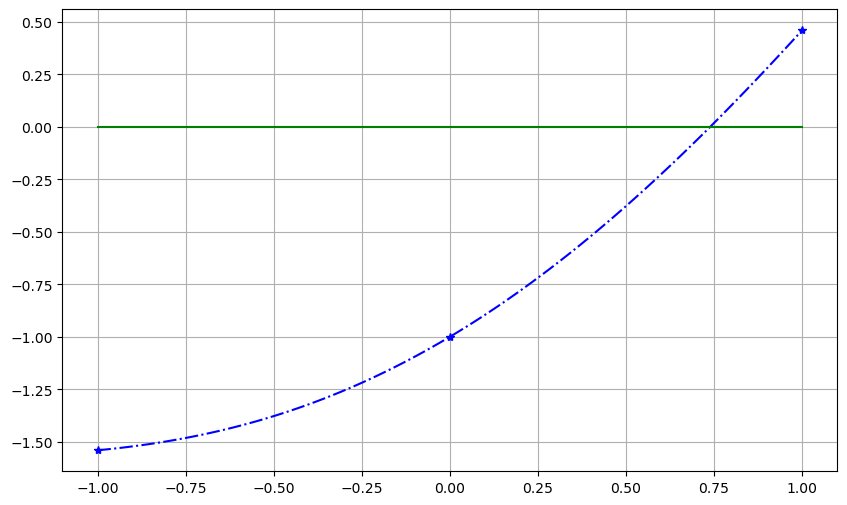

In [7]:
acb = [a c b]
figure(figsize=[10,6])
plot(acb, f.(acb), "b*")
# And just as a visual aid:
x = range(a, b, 100)
plot(x, f.(x), "b-.")
plot([a, b], [0, 0], "g")
grid(true)

$f(a)$ and $f(c)$ have the same sign, while $f(c)$ and $f(b)$ have opposite signs, so the root is in $[c, b]$;
update the a, b, c values and plot again:

In [8]:
a = c  # new left end is old center
b = b  # redundant, as the right end is unchanged
c = (a+b)/2
println("a=$a, b=$b, c=$c")

a=0.0, b=1.0, c=0.5


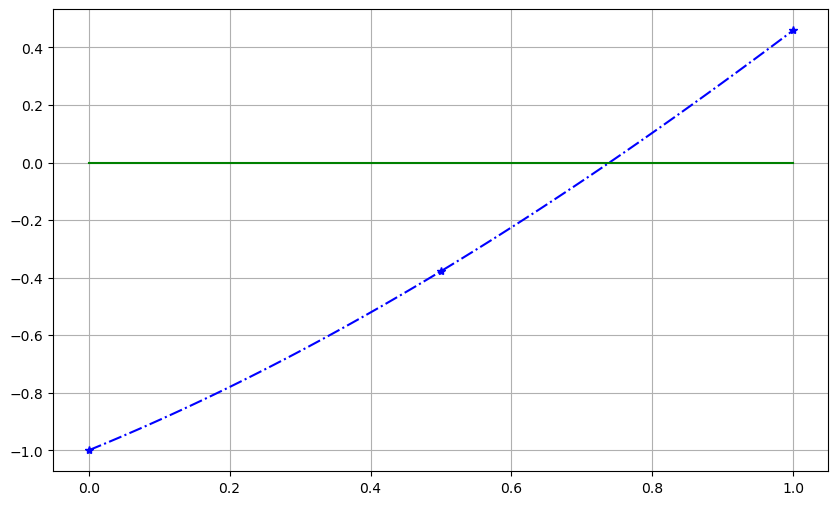

In [9]:
acb = [a c b]
figure(figsize=[10,6])
plot(acb, f.(acb), "b*")
x = range(a, b, 100)
plot(x, f.(x), "b-.")
plot([a, b], [0, 0], "g")
grid(true)

Again $f(c)$ and $f(b)$ have opposite signs, so the root is in $[c, b]$, and ...

In [10]:
a = c  # new left end is old center again
# skipping the redundant "b = b" this time
c = (a+b)/2
println("a=$a, b=$b, c=$c")

a=0.5, b=1.0, c=0.75


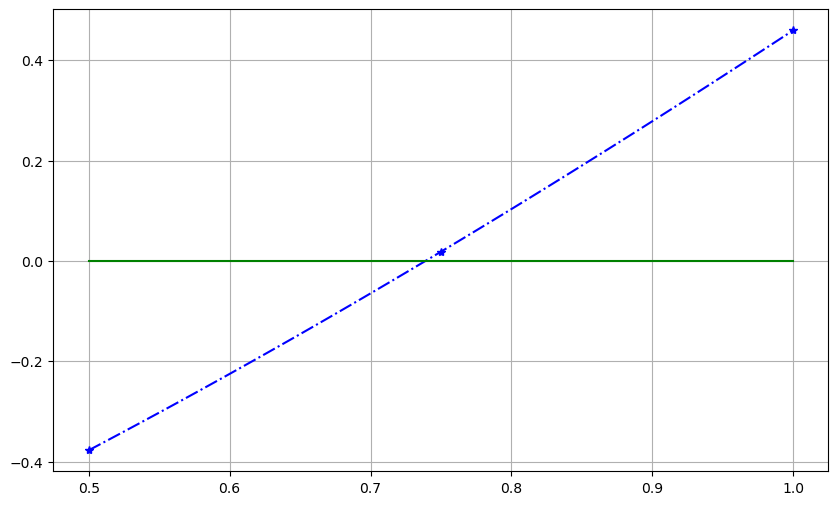

In [11]:
acb = [a c b]
figure(figsize=[10,6])
plot(acb, f.(acb), "b*")
x = range(a, b, 100)
plot(x, f.(x), "b-.")
plot([a, b], [0, 0], "g")
grid(true)

This time $f(a)$ and $f(c)$ have opposite sign, so the root is at left, in $[a, c]$:

In [12]:
# this time, the value of a does not need to be updated ...
b = c  # ... and the new right end is the former center
c = (a+b)/2
println("a=$a, b=$b, c=$c")

a=0.5, b=0.75, c=0.625


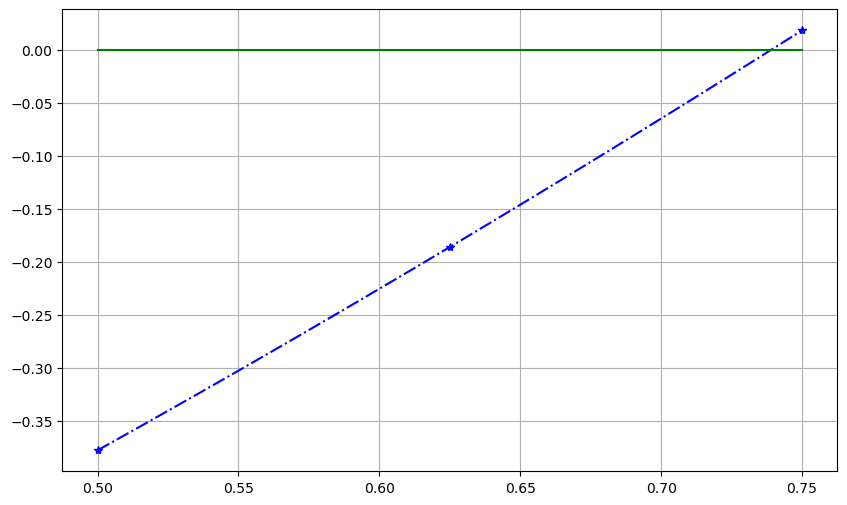

In [13]:
acb = [a c b]
figure(figsize=[10,6])
plot(acb, f.(acb), "b*")
x = range(a, b, 100)
plot(x, f.(x), "b-.")
plot([a, b], [0, 0], "g")
grid(true)

## A first algorithm for the bisection method

Now it is time to dispense with the graphs, and describe the procedure in mathematical terms:
- if $f(a)$ and $f(c)$ have opposite signs, the root is in interval $[a, c]$, which becomes the new version of interval $[a, b]$.
- otherwise, $f(c)$ and $f(b)$ have opposite signs, so the root is in interval $[c, b]$

### Pseudo-code for describing algorithms

As a useful bridge from the mathematical desciption of an algorithm with words and formulas to actual executable code,
these notes will often describe algorithms in *pseudo-code* —
a mix of words and mathematical formulas with notation that somewhat resembles code in a language like Julia.

This is also preferable to going straight to code in a particular programming language (such as Julia) because it makes it easier if, later, you wish to implement algorithms in a different language.

Note well one feature of the pseudo-code used here:
**assignment** is denoted with a left arrow:

$x \leftarrow a$

is the instruction to cause the value of variable `x` to become the current value of a.

This is to distinguish from

$x = a$

which is a **comparison**: the true-or-false assertion that the two quantities _already_ have the same value.

Unfortunately however, Julia (like most programming languages) does not use this notation:
instead assignment is done with `x = a` so that asserting equality needs a differnt notation:
this is done with `x == a`; note well that double equal sign!

With that notational issue out of the way,
the key step in the bisection strategy is the update of the interval:

```{prf:algorithm} one step of bisection
:label: bisection-step
<br>$\displaystyle c \leftarrow \frac{a + b}{2}$
<br>if $f(a) f(c) < 0$ then
<br>$\quad$ $b \leftarrow c$
<br>else
<br>$\quad$ $a \leftarrow c$
<br>end
```

This needs to be repeated a finite number of times, and the simplest way is to specify the number of iterations.
(We will consider more refined methods soon.)

```{prf:algorithm} bisection, first version
:label: bisection-for

- Get an initial interval $[a, b]$ with a sign-change: $f(a) f(b) < 0$.

- Choose $N$, the number of iterations.

- for i from 1 to N
<br>$\quad$ $\displaystyle c \leftarrow \frac{a + b}{2}$
<br>$\quad$ if $f(a) f(c) < 0$ then
<br>$\quad$$\quad$ $b \leftarrow c$
<br>$\quad$ else:
<br>$\quad$$\quad$ $a \leftarrow c$
<br>$\quad$ end
<br>end

- The approximate root is the final value of $c$.
```

A Julia version of the iteration is not a lot different:

    for i in 1:N
        c = (a+b)/2
        if f(a) * f(c) < 0
            b = c
        else
            a = c
        end
    end

```{prf:remark} On Julia
:label: julia-iteration-conditionals
See the notes on [Iteration](julia-language-notes#iteration) and [Conditionals](julia-language-notes##condititionals) on the syntax seen here for first time.
```

See [Exercise A](#exercise-a).

## Error bounds, and a more refined algorithm

The above method of iteration for a fixed number of times is simple, but usually not what is wanted in practice.
Instead, a better goal is to get an approximation with a guaranteed maximum possible error:
a result consisting of an approximation $\tilde{r}$ to the exact root $r$ and also a bound $E_{max}$ on the maximum possible error; a guarantee that $|r - \tilde{r}| \leq E_{max}$.
To put it another way, a guarantee that the root $r$ lies in the interval $[\tilde{r} - E_{max}, \tilde{r} + E_{max}]$.

In the above example, each iteration gives a new interval $[a, b]$ guaranteed to contain the root,
and its midpoint $c = (a+b)/2$ is with a distance $(b-a)/2$ of any point in that interval, so at each iteration, we can have:
- $\tilde{r}$ is the current value of $c = (a+b)/2$
- $E_{max} = (b-a)/2$

## Error tolerances and stopping conditions

The above algorthm can *passively* state an error bound, but it is better to be able to solve to a desired degree of accuracy;
for example, if we want a result "accurate to three decimal places", we can specify $E_{max} \leq 0.5 \times 10^{-3}$.

So our next goal is to *actively* set an accuracy target or *error tolerance* $E_{tol}$ and keep iterating until it is met.
This can be achieved with a `while` loop; here is a suitable algorithm:

```{prf:algorithm} bisection with error tolerance
:label: bisection-while
- Input function $f$, interval endpoints $a$ and $b$, and an error tolerance $E_{tol}$

- Evaluate $E_{max} = (b-a)/2$

- while $E_{max} > E_{tol}$:
<br>$\quad c \leftarrow (a+b)/2$
<br>$\quad$ if $f(a) f(c) < 0$ then
<br>$\quad\quad b \leftarrow c$
<br>$\quad$ else
<br>$\quad\quad a \leftarrow c$
<br>$\quad$ end
<br>$\quad E_{max} \leftarrow (b-a)/2$
<br>end

- Output $\tilde{r} = c$ as the approximate root and $E_{max}$ as a bound on its absolute error.
```

---
## Exercises

<a name="exercise-a"></a>
### Exercise A

Create a Julia function `bisection1` which implements the first algorithm for bisection above,
which performs a fixed number $N$ of iterations;
the usage should be:
`root = bisection1(f, a, b, N)`
 
Test it with the above example:
$f(x) = x - \cos x = 0$, $[a, b] = [-1, 1]$

Julia newcomers: see the notes introducing [Julia Functions](julia-language-notes#functions1).

<a name="exercise-b"></a>
### Exercise B

Create a Julia function implementing this better algorithm, with usage
`root = bisection2(f, a, b, E_tol)`

Test it with the above example: $f(x) = x - \cos x$, $[a, b] = [-1, 1]$,
this time accurate to within $10^{-4}$.

Use the fact that there is a solution in the interval $(-1, 1)$.